In [2]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex,display
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns
import ujson as uj
sns.set()
sns.set_palette('bright')
from molecular_structure import MoleculeLevels
from energy_levels import branching_ratios, calculate_TDMs,calculate_TDM_evecs, calculate_forbidden_TDM_evecs, calculate_forbidden_TDMs
from functools import partial
np.set_printoptions(precision=9, suppress=True)
# from tabulate import tabulate
from matplotlib.collections import LineCollection

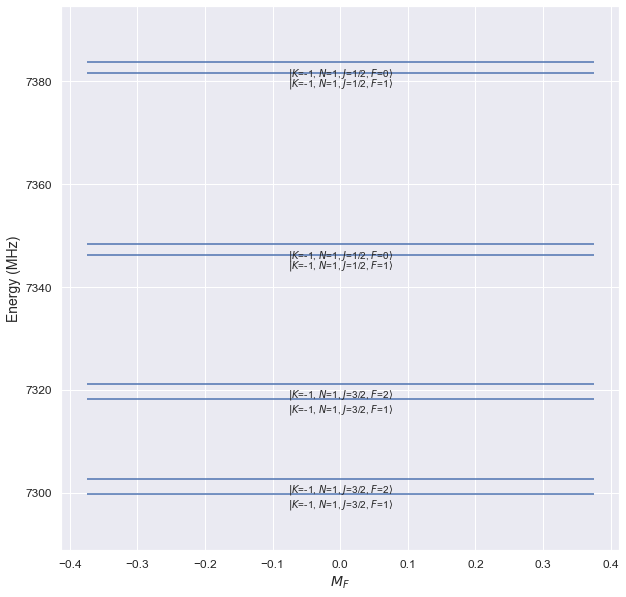

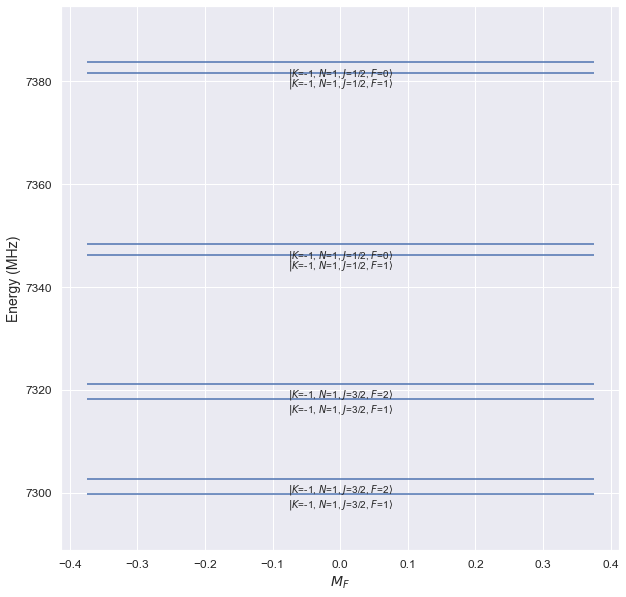

In [33]:
g.display_levels(0,0,'F')

In [8]:
def plotFitComparison(xscale,data,function,params,sigma,xlabel=None,ylabel=None):
    plt.figure()
    plt.title('Fit vs Data')
    if sigma is None:
        plt.plot(xscale,data,label='Data',marker='o')
    else:
        plt.errorbar(xscale,data,yerr=sigma,label='Data',marker='o',linestyle='None')
    plt.plot(xscale,function(xscale,*params),label='Fit')
    return

def plotFitResiduals(xscale,residuals,sigma):
    plt.figure()
    plt.title('Fit Residuals')
    if sigma is None:
        plt.plot(xscale,residuals,'o',linestyle='None')
    else:
        plt.errorbar(xscale,residuals,yerr=sigma,marker='o',linestyle='None')
    plt.plot(xscale,np.zeros(len(xscale)),linestyle='--')
    return

from lmfit import minimize, Parameters
import time

def hyperfine_residual(params,data_lines,data_error,update_params,no_uncert=False):
    X_update = {}
    for p_str in update_params:
        if '_X' in p_str:
            p_name = p_str[:-2]
            X_update[p_name] = params[p_str].value
    if X_update != {}:
        g.update_params(X_update)
        e.update_params(X_update)
    E=0
    B=0
    g.eigensystem(E,B)
    e.eigensystem(E,B)
        
    pos_predicted = []
    neg_predicted = []
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':1},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':2},parity='+')])
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':2},parity='+')])
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':1},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='+')])
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='+')])

    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':1},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':2},parity='-')])
    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':2},parity='-')])
    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':1},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='-')])
    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='-')])

    total_predicted = np.concatenate((pos_predicted,neg_predicted))[:,0]
    
    data_uncertainty = data_error
    if no_uncert:
        data_uncertainty=1
    total_diff=(data_lines - total_predicted)/data_uncertainty
    if 'offset' in params and 'offset' in update_params:
        offset = np.ones(len(data_lines))*params['offset']
        total_diff=(data_lines - total_predicted - offset)/data_uncertainty
    return total_diff

def splitting_residual(params,data_splittings,data_error,update_params,no_uncert=False):
    X_update = {}
    for p_str in update_params:
        if '_X' in p_str:
            p_name = p_str[:-2]
            X_update[p_name] = params[p_str].value
    if X_update != {}:
        g.update_params(X_update)
        e.update_params(X_update)
    E=0
    B=0
    g.eigensystem(E,B)
    e.eigensystem(E,B)
        
    pos_predicted = []
    neg_predicted = []
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[1/2],'F':1},parity='+')])
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[1/2],'F':1},parity='+')])
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[3/2],'F':2},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='+')])
    pos_predicted.append(e.evals0[e.select_q({'N':[1],'J':[3/2],'F':2},parity='+')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='+')])

    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[1/2],'F':1},parity='-')])
    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[1/2],'F':0},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[1/2],'F':1},parity='-')])
    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[3/2],'F':2},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='-')])
    neg_predicted.append(e.evals0[e.select_q({'N':[1],'J':[3/2],'F':2},parity='-')] - g.evals0[g.select_q({'N':[1],'J':[3/2],'F':1},parity='-')])

    total_predicted = np.concatenate((pos_predicted,neg_predicted))[:,0]
    
    data_uncertainty = data_error
    if no_uncert:
        data_uncertainty=1
    total_diff=(data_splittings - total_predicted)/data_uncertainty
    if 'offset' in params and 'offset' in update_params:
        offset = np.ones(len(data_splittings))*params['offset']
        total_diff=(data_splittings - total_predicted - offset)/data_uncertainty
    return total_diff

In [18]:
pos_fit_freq = np.array([60.4167975, 62.398224,  63.287247,  65.395268]).round(3)
pos_fit_err = np.array([0.06275193, 0.04143503, 0.05571958, 0.03731296]).round(3)
pos_fit_err = np.sqrt(pos_fit_err**2 +0.03**2).round(3)
ps = pos_fit_freq
pe = pos_fit_err
pos_splittings = np.array([ps[1]-ps[0], ps[3] - ps[2], ps[2]-ps[0],ps[3]-ps[1]])
#Ordering is 2->0 - 2->1, 1->0 - 1->1, 1->1 - 2->1, 1->0 - 2->0
pos_split_err = np.array([np.sqrt(pe[1]**2+pe[0]**2),np.sqrt(pe[3]**2+pe[2]**2),np.sqrt(pe[2]**2+pe[0]**2),np.sqrt(pe[3]**2+pe[1]**2),])

In [19]:
neg_fit_freq = np.array([43.48121, 45.5, 46.29460333, 48.498919]).round(3)
# neg_fit_err = np.array([0.08164678, 0.12806248, 0.09131569, 0.09809826]).round(3)
neg_fit_err = np.array([0.01631553, 0.1,        0.04402902, 0.05677385]).round(3)
neg_fit_err = np.sqrt(neg_fit_err**2 + 0.06**2).round(3)
ns = neg_fit_freq
ne = neg_fit_err
neg_splittings = np.array([ns[1]-ns[0], ns[3] - ns[2], ns[2]-ns[0],ns[3]-ns[1]])
#Ordering is 2->0 - 2->1, 1->0 - 1->1, 1->1 - 2->1, 1->0 - 2->0
neg_split_err = np.array([np.sqrt(ne[1]**2+ne[0]**2),np.sqrt(ne[3]**2+ne[2]**2),np.sqrt(ne[2]**2+ne[0]**2),np.sqrt(ne[3]**2+ne[1]**2),])

In [20]:
total_fit_freq = np.concatenate((pos_fit_freq,neg_fit_freq))
total_fit_err = np.concatenate((pos_fit_err,neg_fit_err))
total_split_freq = np.concatenate((pos_splittings,neg_splittings))
total_split_err = np.concatenate((pos_split_err,neg_split_err))

In [25]:
print(pos_fit_freq)
print(pos_fit_err*2)

[60.417 62.398 63.287 65.395]
[0.14  0.102 0.128 0.096]


In [26]:
print(neg_fit_freq)
print(neg_fit_err*2)

[43.481 45.5   46.295 48.499]
[0.124 0.234 0.148 0.166]


In [22]:
g = MoleculeLevels.initialize_state('YbOH','174','X010',[1],M_values = 'custom',M_range=[0],I=[0,1/2],S=1/2,round=8,P_values=[1/2,3/2])
e = g
g.eigensystem(0,0)
e.eigensystem(0,0)
gidx = g.select_q({'N':[1],'J':[3/2]})
eidx = e.select_q({'N':[1],'J':[1/2]})

Text(0.5, 1.0, 'Prior stdev = 0.09525723290219906')

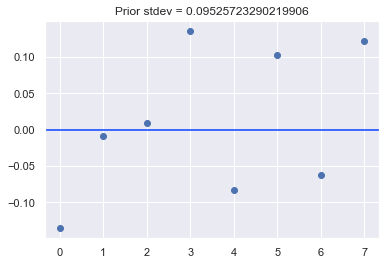

In [23]:
# dataset = All_StarkZeeman_Data['20220526']
params = Parameters()
params.add('Gamma_SR_X',value=-88.660,min=-90,max=-86,vary=False)
params.add('Gamma_Prime_X',value=15.61,min=-30,max=30,vary=False)
# params.add('d_X',value=0.0, min = -10,max=10,vary=False)
params.add('offset',value=0,min=-5,max=5,vary=False)
params.add('q_lD_X',value=-12.03,min=-14,max=-10,vary=False)
params.add('p_lD_X',value=-10.73,min=-14,max=-6,vary=False)
params.add('bF_X',value=3.97,min=-10,max=10,vary=True)
params.add('c_X',value=3.78,min=-10,max=10,vary=True)
update_params = ['bF_X','c_X','Gamma_SR_X','Gamma_Prime_X','q_lD_X','p_lD_X','offset']

initial_resid = splitting_residual(params,total_split_freq,total_split_err,update_params,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('Prior stdev = '+ str(initial_resid.std()))

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Gamma_Prime_X     15.61      -30       30        0    False     None     None
Gamma_SR_X       -88.66      -90      -86        0    False     None     None
bF_X               4.07      -10       10  0.08577     True     None     None
c_X               3.487      -10       10    0.188     True     None     None
offset                0       -5        5        0    False     None     None
p_lD_X           -10.73      -14       -6        0    False     None     None
q_lD_X           -12.03      -14      -10        0    False     None     None


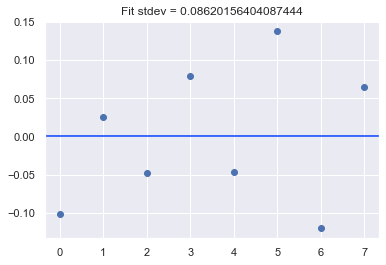

5.273640155792236 sec


In [24]:
t1 = time.time()
out = minimize(splitting_residual, params, args=([total_split_freq,total_split_err,update_params]),method='least_squares')#,kws={'flist':True})#,method='least_squares')
t2 = time.time()
out.params.pretty_print()
final_resid = splitting_residual(out.params,total_split_freq,total_split_err,update_params,no_uncert=True)
plt.figure()
plt.plot(final_resid, 'bo')
plt.axhline(y=0)
plt.title('Fit stdev = '+ str(final_resid.std()))
plt.show()
print(t2-t1,'sec')

out_w_pg_gp = out

In [70]:
total_split_err

array([0.086608314, 0.08       , 0.094847246, 0.070035705, 0.132412235,
       0.111198022, 0.096540147, 0.14345034 ])

In [17]:
out

Text(0.5, 1.0, 'Prior stdev = 0.42903036893787655')

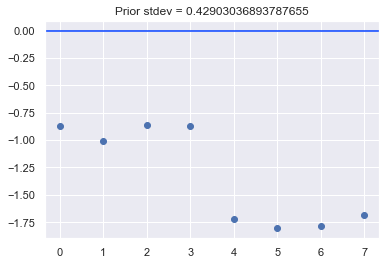

In [27]:
# dataset = All_StarkZeeman_Data['20220526']
params = Parameters()
params.add('Gamma_SR_X',value=-88.660,min=-90,max=-86,vary=False)
params.add('Gamma_Prime_X',value=15.61,min=-30,max=30,vary=True)
params.add('d_X',value=0.0, min = -10,max=10,vary=False)
params.add('offset',value=0,min=-5,max=5,vary=False)
params.add('q_lD_X',value=-12.03,min=-14,max=-10,vary=False)
params.add('p_lD_X',value=-10.73,min=-14,max=-6,vary=True)
params.add('bF_X',value=3.97,min=-10,max=10,vary=True)
params.add('c_X',value=3.78,min=-10,max=10,vary=True)
update_params = ['bF_X','c_X','Gamma_SR_X','Gamma_Prime_X','q_lD_X','p_lD_X','offset','d_X']

initial_resid = hyperfine_residual(params,total_fit_freq,total_fit_err,update_params,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('Prior stdev = '+ str(initial_resid.std()))

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Gamma_Prime_X     17.38      -30       30  0.03344     True     None     None
Gamma_SR_X       -88.66      -90      -86        0    False     None     None
bF_X              4.084      -10       10  0.06008     True     None     None
c_X               3.414      -10       10   0.1445     True     None     None
d_X                   0      -10       10        0    False     None     None
offset                0       -5        5        0    False     None     None
p_lD_X            -11.3      -14       -6  0.03458     True     None     None
q_lD_X           -12.03      -14      -10        0    False     None     None


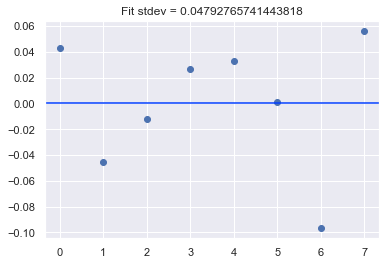

12.839310646057129 sec


In [28]:
t1 = time.time()
out = minimize(hyperfine_residual, params, args=([total_fit_freq,total_fit_err,update_params]),method='least_squares')#,kws={'flist':True})#,method='least_squares')
t2 = time.time()
out.params.pretty_print()
final_resid = hyperfine_residual(out.params,total_fit_freq,total_fit_err,update_params,no_uncert=True)
plt.figure()
plt.plot(final_resid, 'bo')
plt.axhline(y=0)
plt.title('Fit stdev = '+ str(final_resid.std()))
plt.show()
print(t2-t1,'sec')

out_w_pg_gp = out

In [29]:
out

In [ ]:
# dataset = All_StarkZeeman_Data['20220526']
params = Parameters()
params.add('Gamma_SR_X',value=-88.660,min=-90,max=-86,vary=False)
params.add('Gamma_Prime_X',value=15.61,min=-30,max=30,vary=True)
params.add('q_lD_X',value=-12.03,min=-14,max=-10,vary=False)
params.add('p_lD_X',value=-10.73,min=-14,max=-6,vary=True)
params.add('bF_X',value=3.97,min=-10,max=10,vary=True)
params.add('c_X',value=3.78,min=-10,max=10,vary=True)
update_params = ['bF_X','c_X','Gamma_SR_X','Gamma_Prime_X','q_lD_X','p_lD_X']

initial_resid = hyperfine_residual(params,total_fit_freq,total_fit_err,update_params,no_uncert=True)
plt.figure()
plt.plot(initial_resid, 'bo')
plt.axhline(y=0)
plt.title('Prior stdev = '+ str(initial_resid.std()))

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Gamma_Prime_X     15.61      -30       30        0    False     None     None
Gamma_SR_X       -88.66      -90      -86        0    False     None     None
bF_X              2.954      -10       10     1.23     True     None     None
c_X               2.925      -10       10    3.208     True     None     None
p_lD_X           -10.73      -20       20        0    False     None     None
q_lD_X           -12.03      -20       20        0    False     None     None


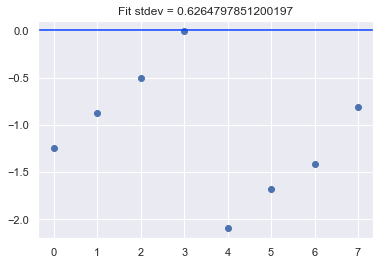

3.436126470565796 sec


In [81]:
t1 = time.time()
out = minimize(hyperfine_residual, params, args=([total_fit_freq,total_fit_err,update_params]),method='least_squares')#,kws={'flist':True})#,method='least_squares')
t2 = time.time()
out.params.pretty_print()
final_resid = hyperfine_residual(out.params,total_fit_freq,total_fit_err,update_params,no_uncert=True)
plt.figure()
plt.plot(final_resid, 'bo')
plt.axhline(y=0)
plt.title('Fit stdev = '+ str(final_resid.std()))
plt.show()
print(t2-t1,'sec')

out_w_gp = out